In [25]:
import pydicom
import matplotlib.pyplot as plt
import os
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
os.listdir()

['EDA.ipynb', 'DICOMDAT', 'rotation.gif', 'Weng Jinzhu', '.ipynb_checkpoints']

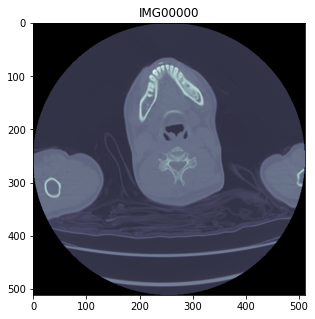

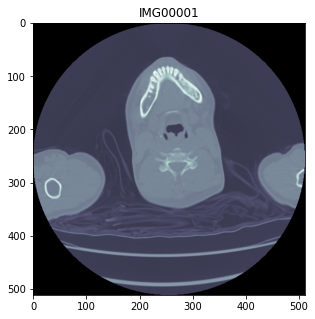

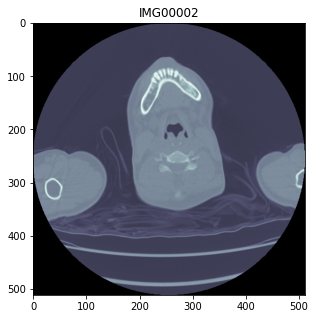

In [26]:
dir = './DICOMDAT/SDY00000/SRS00001/'
for file in sorted(os.listdir(dir))[:3]:
    ds = pydicom.dcmread(dir+file)
    plt.figure(figsize=(5,5))
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.title(file)
    plt.show()

In [27]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [28]:
def load_scan(files):
    slices = [pydicom.read_file(dir+f) for f in files]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [29]:
files = sorted(os.listdir(dir))
files[0],files[-1]

('IMG00000', 'IMG00160')

In [30]:
slice = load_scan(files)

In [31]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # 转换为int16，int16是ok的，因为所有的数值都应该 <32k
    image = image.astype(np.int16)

    # 设置边界外的元素为0
    image[image == -2000] = 0

    # 转换为HU单位
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

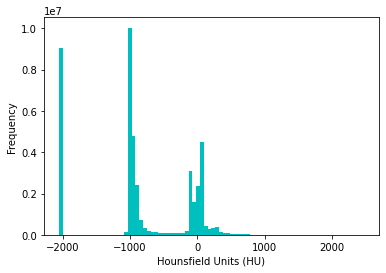

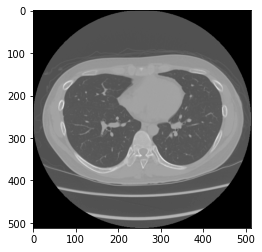

In [32]:
first_patient = slice
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# 显示一个中间位置的切片
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [33]:
def resample(image, scan, new_spacing=[1,1,1]):
    spacing = np.array([float(scan[0].SliceThickness)] + [float(x) for x in scan[0].PixelSpacing], dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    new_shape[0] = len(image)
    print(new_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    return image, new_spacing

pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

[161. 370. 370.]
Shape before resampling	 (161, 512, 512)
Shape after resampling	 (161, 370, 370)


In [34]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces

def plotly_3d(verts, faces):
    x,y,z = zip(*verts) 
    
    print("Drawing")
    
    # Make the colormap single color since the axes are positional not intensity. 
#    colormap=['rgb(255,105,180)','rgb(255,255,51)','rgb(0,191,255)']
    colormap=['rgb(236, 236, 212)','rgb(236, 236, 212)']
    
    fig = FF.create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        colormap=colormap,
                        simplices=faces,
                        backgroundcolor='rgb(64, 64, 64)',
                        title="Interactive Visualization")
    iplot(fig)

def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [1, 1, 0.9]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    ax.set_axis_bgcolor((0.7, 0.7, 0.7))
    plt.show()

In [1]:
#v, f = make_mesh(pix_resampled, 350, 2)
#plotly_3d(v, f)